In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import glob
from IPython.display import display
import sys

In [21]:
%load_ext autoreload
%autoreload 2
sys.path.insert(0, '../../scripts')
from plot_helpers import nice_name_map, plot_scatter_with_lines, save_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
benchmark_results = []
for path in glob.glob('../../benchmarks/2020-12-16-independent-large-2Mio-regen-1-rep-1/*.csv'):
    benchmark_results.append(pd.read_csv(path))
benchmark_results = pd.concat(benchmark_results)

benchmark_results.sample(5)

,generation_config_i,input_strategy,input_length_1,input_change_strength,input_chunkiness,input_distribution,regen_i,repetition_i,diff_program,mpi_procs,timeout_seconds,mpi_comm_world,micros_input,micros_precompute,micros_until_len,micros_edit_script,min_edit_length
1,5,independent,1211111,1,0,zipf,0,0,mpi_no_master_frontier,512,1200.0,512,2291554,0,24221722,0,2132142
3,0,independent,100000,1,0,zipf,0,0,mpi_no_master_frontier,512,1200.0,512,1399932,0,324388,0,171146
0,6,independent,1433333,1,0,zipf,0,0,mpi_no_master_frontier,256,1200.0,256,5618909,0,59609342,0,2526988
3,0,independent,100000,1,0,zipf,0,0,mpi_no_master_frontier,256,1200.0,256,271777,0,1058512,0,171146
1,5,independent,1211111,1,0,zipf,0,0,mpi_priority_frontier,128,1200.0,128,218594,0,101169172,0,2132142


In [6]:
def agg_only(values):
    assert len(values) == 1
    return values.iloc[0]

def prepare_plot_data(filter_cb, index, map_cb = lambda temp: temp):
    temp = benchmark_results.copy()
    temp = map_cb(temp)
    temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
    temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).agg(agg_only)
    temp = filter_cb(temp)
    temp = temp.set_index(index, append=True)
    temp = temp.unstack('mpi_procs')['micros_until_len']
    temp = temp.droplevel('generation_config_i')
    temp = temp.sort_index()
    return temp

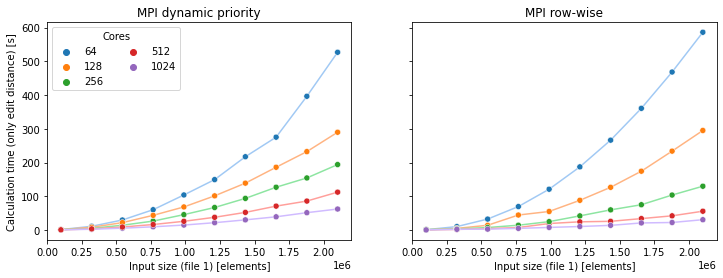

In [22]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
    temp = benchmark_results.copy()
    temp['seconds_until_len'] = temp['micros_until_len'] * 1e-6
    temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]
    
    temp_2 = temp.groupby(['input_length_1', 'mpi_procs'])['seconds_until_len'].median().unstack('mpi_procs')
    
    this_ax = ax[diff_program_i]
    plot_scatter_with_lines(
        ax=this_ax,
        scatter_data=temp,
        line_data=temp_2,
        x_key='input_length_1',
        y_key='seconds_until_len',
        hue_key='mpi_procs',
        show_legend=diff_program_i == 0,
    )
    this_ax.set_title(nice_name_map[diff_program])
    
save_plot(fig, 'independent-large-raw-times')

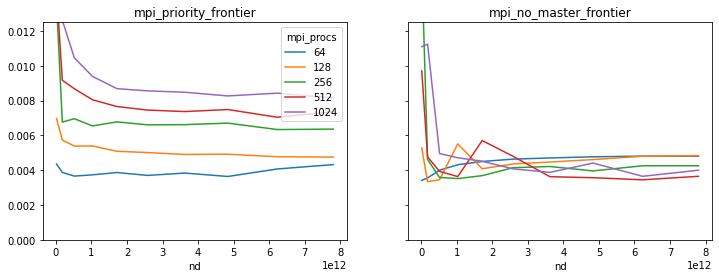

In [15]:
def map_data_for_plot(temp):
    temp['nd'] = temp['input_length_1'] * temp['min_edit_length']
    temp['micros_until_len'] = temp['micros_until_len'] * temp['mpi_procs'].fillna(1) / temp['nd']
    return temp

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
    temp = prepare_plot_data(
        lambda temp: temp[(temp.index.get_level_values('diff_program') == diff_program) & (temp['input_strategy'] == 'independent')],
        'nd',
        map_data_for_plot,
    )
    temp = temp.droplevel('diff_program')
    temp.plot(ax=ax[diff_program_i], legend=(diff_program_i == 0), title=diff_program, ylim=(0, 0.0125));

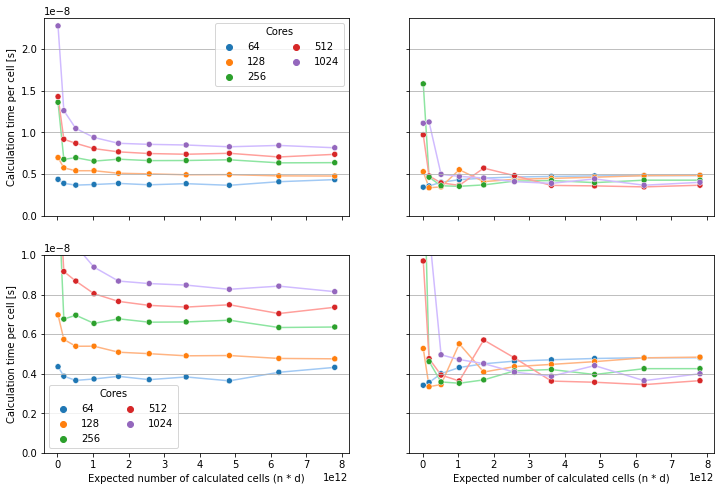

In [23]:
palette = {mpi_procs: color for mpi_procs, color in zip(sorted(benchmark_results.mpi_procs.dropna().unique()), sns.color_palette())}
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey='row')
for y_lim_i, y_lim in enumerate([(0, None), (0, 1e-8)]):
    for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
        temp = benchmark_results.copy()
        temp = temp[(temp['diff_program'] == diff_program) & (temp['input_strategy'] == 'independent')]
        temp['nd'] = temp['input_length_1'] * temp['min_edit_length']
        temp['seconds_per_cell'] = temp['micros_until_len'] * temp['mpi_procs'].fillna(1) / temp['nd'] * 1e-6
        
        temp_2 = temp.groupby(['nd', 'mpi_procs'])['seconds_per_cell'].median().unstack('mpi_procs')
        
        this_ax = ax[y_lim_i][diff_program_i]
        plot_scatter_with_lines(
            ax=this_ax,
            scatter_data=temp,
            line_data=temp_2,
            x_key='nd',
            y_key='seconds_per_cell',
            hue_key='mpi_procs',
            show_legend=diff_program_i == 0,
        )
        this_ax.set_ylim(*y_lim)
        this_ax.grid(axis='y')
        
save_plot(fig, 'independent-large-cell-times')

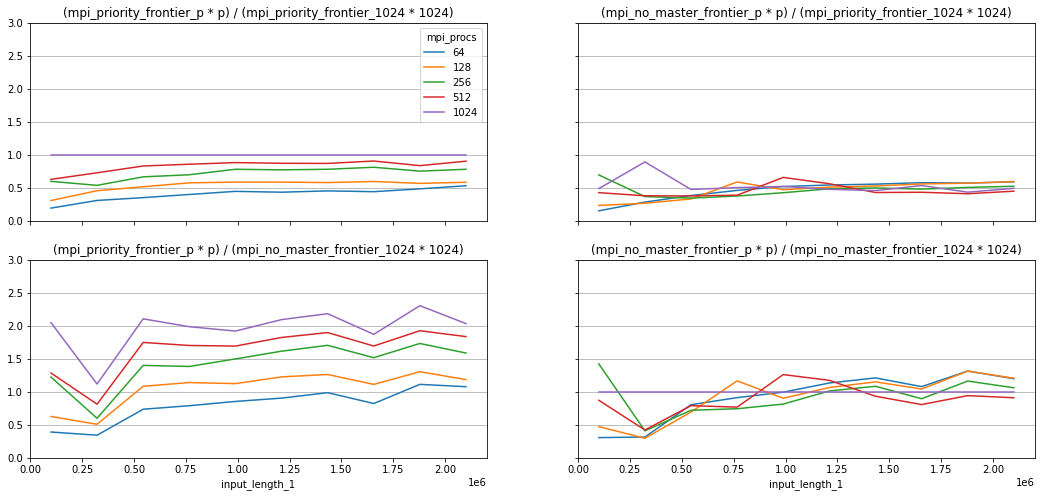

In [16]:
reference_cores = 1024

fig, ax = plt.subplots(2, 2, figsize=(18, 8), sharex=True, sharey=True)
for diff_program_i, diff_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
    for reference_program_i, reference_program in enumerate(['mpi_priority_frontier', 'mpi_no_master_frontier']):
        temp = benchmark_results.copy()
        temp['mpi_procs'] = temp['mpi_procs'].fillna('sequential')
        temp = temp.groupby(['generation_config_i', 'mpi_procs', 'diff_program']).min()
        temp = temp[temp['input_strategy'] == 'independent']
        temp_2 = temp.xs(diff_program, level='diff_program').set_index("input_length_1", append=True)["micros_until_len"].unstack("mpi_procs").droplevel(0)
        temp_3 = temp.xs(reference_program, level='diff_program').xs(reference_cores, level='mpi_procs').set_index("input_length_1")["micros_until_len"]
        temp = temp_2.divide(temp_3, axis=0)
        temp *= temp.columns.values / reference_cores
        temp.plot(ax=ax[reference_program_i][diff_program_i], legend=(reference_program_i == 0 and diff_program_i == 0), title=f'({diff_program}_p * p) / ({reference_program}_{reference_cores} * 1024)', ylim=(0, 3), grid=True);
        ax[reference_program_i][diff_program_i].grid(axis='x')